# Street Traffic Based Space Dilation/Contraction 

---

### Initial Imports and Pre-Settings 

In [1]:
import glob
import json

import seaborn as sns
import matplotlib.pyplot as plt

import geopy.distance
import numpy as np
import pandas as pd

---

### Data Reading and Wrangling 

In [2]:
raw_data = pd.read_csv(glob.glob('*.csv')[0])
geozones = json.load(open(glob.glob(('*.json'))[0], 'r', encoding='utf-8'))

In [3]:
zones_df = pd.DataFrame(geozones['features'])
zones_df.loc[:, 'coordinates'] = zones_df.geometry.apply(lambda x: np.mean(x['coordinates'][0], 0))
zones_df.loc[:, 'movement_id'] = zones_df.properties.apply(lambda x: x['MOVEMENT_ID']).astype(int)
zones_df.loc[:, 'display_name'] = zones_df.properties.apply(lambda x: x['DISPLAY_NAME'])
zones_df = zones_df[zones_df.coordinates.apply(lambda x: len(x)) == 2]
zones_df = zones_df[['movement_id', 'display_name', 'coordinates']]

In [4]:
data = raw_data.merge(zones_df.rename(columns={'movement_id': 'sourceid'}), how='inner', on='sourceid')
data.rename(columns={'display_name': 'from', 'coordinates': 'coord_1'}, inplace=True)
data = data.merge(zones_df.rename(columns={'movement_id': 'dstid'}), how='inner', on='dstid')
data.rename(columns={'display_name': 'to', 'coordinates': 'coord_2'}, inplace=True)

data.loc[:, 'transition'] = data['from'] + ' -> ' + data['to']

In [5]:
data.loc[:, 'x0'] = data.coord_1.apply(lambda x: x[0])
data.loc[:, 'xf'] = data.coord_2.apply(lambda x: x[0])
data.loc[:, 'y0'] = data.coord_1.apply(lambda x: x[1])
data.loc[:, 'yf'] = data.coord_2.apply(lambda x: x[1])

data.loc[:, 'theta'] = np.arctan((data.yf - data.y0) / (data.xf - data.x0))

At first I will be applying euclidian distance based on lat/lon for the sake on simplicity.

In [6]:
# unique_transitions = data[['transition', 'coord_1', 'coord_2']].drop_duplicates(subset=['transition']).reset_index(drop=True).copy()
# unique_transitions.loc[:, 'distance'] = unique_transitions.apply(lambda x: geopy.distance.geodesic(x['coord_1'], x['coord_2']).m, axis=1)
# data = data.merge(unique_transitions[['transition', 'distance']], on='transition')

data.loc[:, 'distance'] = np.sqrt((data.xf - data.x0) ** 2 + (data.yf - data.y0) ** 2)

In [7]:
time_reference = 'geometric_mean_travel_time'
hod_ref = 3

aux_df = data[data.hod == hod_ref][['transition', time_reference]].copy()
aux_df.rename(columns={'geometric_mean_travel_time': 'partition_norm'}, inplace=True)

data = data.merge(aux_df, on='transition')

In [8]:
data.loc[:, 'norm_time'] = data[time_reference] / data.partition_norm
data.loc[:, 'norm_distance'] = data.norm_time * data.distance
data.loc[:, 'distance_delta'] = data.norm_distance - data.distance

data.loc[:, 'dx'] = data.coord_2.apply(lambda x: x[0]) + np.cos(data.theta) * data.distance_delta
data.loc[:, 'dy'] = data.coord_2.apply(lambda x: x[1]) + np.sin(data.theta) * data.distance_delta

In [9]:
data.sort_values(['from', 'to', 'hod'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [10]:
result = data[['from', 'to', 'hod', 'x0', 'y0', 'xf', 'yf', 'dx', 'dy', 'norm_time', 'norm_distance', 'distance']].copy()

In [11]:
result.sample(5)

,from,to,hod,x0,y0,xf,yf,dx,dy,norm_time,norm_distance,distance
236354,Brás,Estrada das Lágrimas,9,-46.619277,-23.549157,-46.571614,-23.638354,-46.565273,-23.650221,1.133046,0.114588,0.101133
842574,Jardim Miriam,Pari,2,-46.642803,-23.679109,-46.616893,-23.529146,-46.615785,-23.522732,1.042767,0.158693,0.152185
282831,Campestre,Vieira de Moraes,21,-46.548033,-23.640218,-46.671589,-23.625767,-46.656247,-23.627562,1.124172,0.139844,0.124397
301260,Campo Grande,Bandeirantes,2,-46.674494,-23.681029,-46.670161,-23.610877,-46.669839,-23.605670,1.074233,0.075503,0.070286
553341,FAAP,Parque Edu Chaves,0,-46.662521,-23.546153,-46.563179,-23.478091,-46.556603,-23.473586,1.066195,0.128393,0.120421


---

### Tests 

In [12]:
max_dist = result[
    (result['from'] == 'Pinheiros') & 
    (result['to'] == 'Sé')
].distance.max()

In [21]:
df = result[
    (result['from'] == 'Pinheiros') & 
#     (result['to'] == 'Sé') & 
    (result.distance <= max_dist)
].reset_index(drop=True)

In [22]:
df.to_csv('test.csv', index=False)

In [23]:
df.shape

(2280, 12)

In [27]:
df.head()

,from,to,hod,x0,y0,xf,yf,dx,dy,norm_time,norm_distance,distance


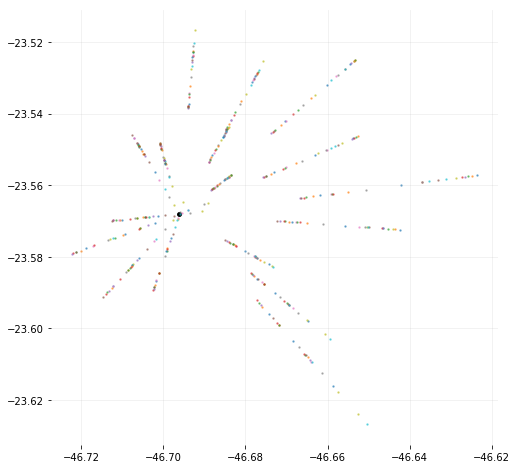

In [15]:
f, ax = plt.subplots(figsize=(8, 8))

x0, y0 = df.iloc[0].x0, df.iloc[0].y0
ax.scatter(x0, y0, s=15, c='k')

for hod in range(24):
    frame = df[df.hod == hod]
    xf, yf = frame.dx, frame.dy
    ax.scatter(xf, yf, s=2, alpha=.5)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(alpha=.2)

plt.show()

In [16]:
transitions = [
    'Pinheiros -> Sé',
]
df = data[(data.transition.isin(transitions))].copy()

In [17]:
colors = ['red' if i == hod_ref else 'gray' for i in range(24)]

Text(0, 0.5, 'Normalized Time (in ref to 3 am)')

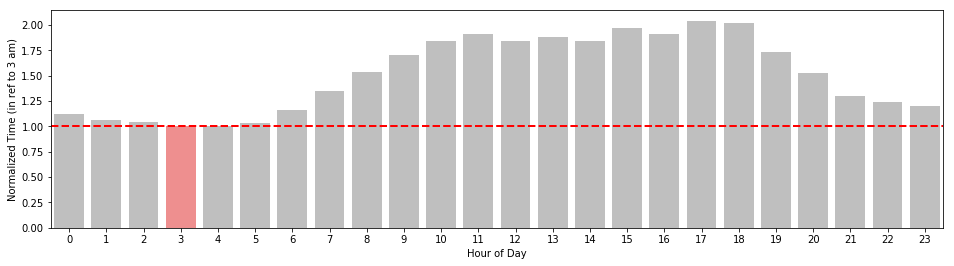

In [18]:
f, ax = plt.subplots(figsize=(16, 4))

sns.barplot(
    x=df.hod,
    y=df.norm_time,
    palette=colors,
    alpha=.5,
    ax=ax
)
ax.axhline(1, ls='--', lw=2, color='r')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Normalized Time (in ref to 3 am)')